In [20]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Count of images in each set

Number of images in train folder: 12601
Number of images in test folder: 5410


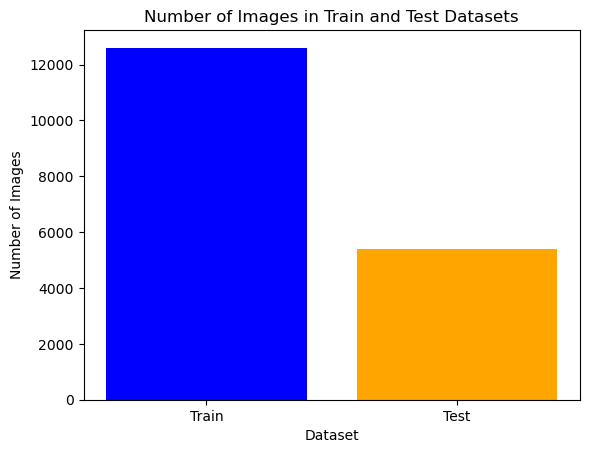

In [1]:

def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
                count += 1
    return count

# Define the paths to the train and test folders
train_folder_path = 'Human Action Recognition/train'
test_folder_path = 'Human Action Recognition/test'

# Count the images in each folder
train_image_count = count_images_in_folder(train_folder_path)
test_image_count = count_images_in_folder(test_folder_path)

# Print the counts
print(f'Number of images in train folder: {train_image_count}')
print(f'Number of images in test folder: {test_image_count}')

# Plotting the bar graph
labels = ['Train', 'Test']
counts = [train_image_count, test_image_count]

plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Number of Images in Train and Test Datasets')
plt.show()
